In [ ]:
# ------------------------------------------ IMPORTS --------------------------------------------------------------------------------------#
import os
import random
import sys
import numpy as np
from scipy.spatial import distance_matrix
import math
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

sys.path.append(os.path.abspath(".."))
from epstein_civil_violence.model import EpsteinCivilViolence

In [ ]:
# -------------------- HELPER FUNCTIONS -----------------------------------------------------------------------------------------------------#
def ripley_l_function(points, radius, area=None):
    """
    Compute Ripley's K-function for a set of 2D points.
    """

    points = np.asarray(points)
    N = len(points)
    if N < 2:
        raise ValueError("Need at least 2 points.")

    if area is None:
        xmin, ymin = points.min(axis=0)
        xmax, ymax = points.max(axis=0)
        area = (xmax - xmin) * (ymax - ymin)

    lambda_density = (N / area)**(-1)
    dists = distance_matrix(points, points)
    np.fill_diagonal(dists, np.inf)

    count = np.sum(dists <= radius)
    L = math.sqrt(((lambda_density*(count/N))/math.pi))

    return L

def preprocess_data(model_out):
    """
    Store aggregated model output data.
    """

    n_steps = len(model_out["citizen"])
    n_people = len(model_out["citizen"][0])

    # Initialize lists
    legitimacies = []
    grievances = []
    positions = []
    active = []
    quiet = []
    arrested = []
    steps = [i for i in range(n_steps)]

    for step in range(n_steps):
        
        # Intiallize sublists for each timestep
        legitimacies.append([])
        grievances.append([])
        positions.append([])
        active = list(model_out["active"])
        quiet = list(model_out["quiet"])
        arrested = list(model_out["arrested"])

        # Fill list with citizen data
        for person in range(n_people):
            legitimacies[step].append(model_out["citizen"][step][person][2])
            grievances[step].append(model_out["citizen"][step][person][3])
            positions[step].append((model_out["citizen"][step][person][0], model_out["citizen"][step][person][1]))

        # Aggregate over all the different agents    
        ripley_indexes = [ripley_l_function(np.array(item), [20]) for item in positions]
        average_grievances = [np.mean(item) for item in grievances]
        average_legitimacies = [np.mean(item) for item in legitimacies]

    
    data = {"steps": steps, "legitimacies": average_legitimacies, "grievances": average_grievances, "ripley_indexes": ripley_indexes, "active": active, "quiet": quiet, "arrested": arrested}
    
    return data

def calculate_interval_and_sizes(data):
    """
    Calculate the sizes of outburst and the intervals
    between them, given the model data.
    """

    # Store outburst data
    dataframe = pd.DataFrame(data)
    outburst_steps = dataframe[dataframe["active"] > 50].index.tolist()
    actives = dataframe[dataframe["active"] > 50]["active"].tolist()
    activity = pd.DataFrame({"step": outburst_steps, "actives": actives})

    # Intitialize
    intervals = []
    sizes = []
    current_size = 0
    
    # Calculate intervals between and sizes of outbursst
    if not activity.empty:

        old_item = activity.iloc[0]

        for i in tqdm(range(1, activity.shape[0])):
            item = activity.iloc[i]
            interval = item[0] - old_item[0]

            if interval != 1:  # A new revolution has started

                # Information is added about previous revolution
                intervals.append(int(interval))
                current_size += item[1]
                sizes.append(int(current_size))
                current_size = 0

            else:  # The revolution is still going

                current_size += item[1]
            
            old_item = item
        
        # Append the size of the last revolution
        sizes.append(int(current_size))
            
    return intervals, sizes


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\frede\AppData\Local\Temp\ipykernel_23180\4234983889.py:94: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  interval = item[0] - old_item[0]
C:\Users\frede\AppData\Local\Temp\ipykernel_23180\4234983889.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_size += item[1]
100%|██████████| 2/2 [02:40<00:00, 80.23s/it] 


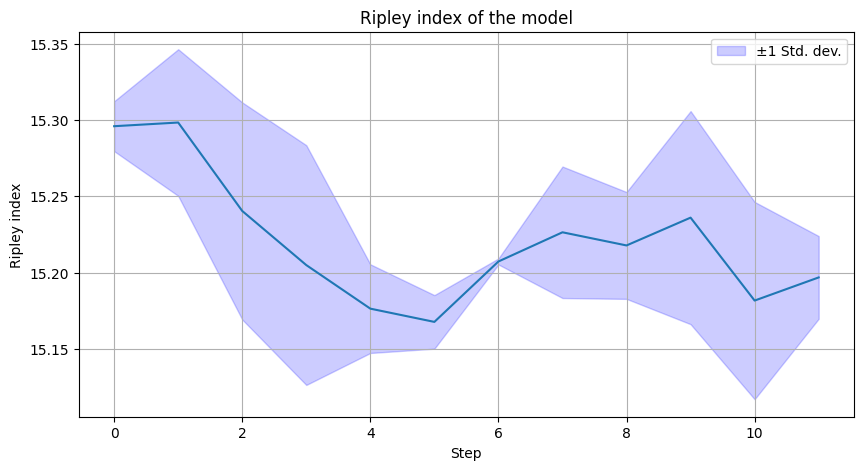

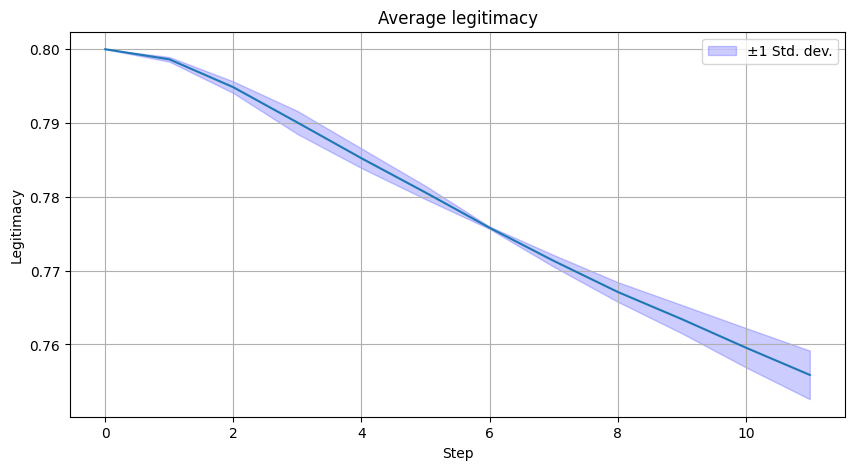

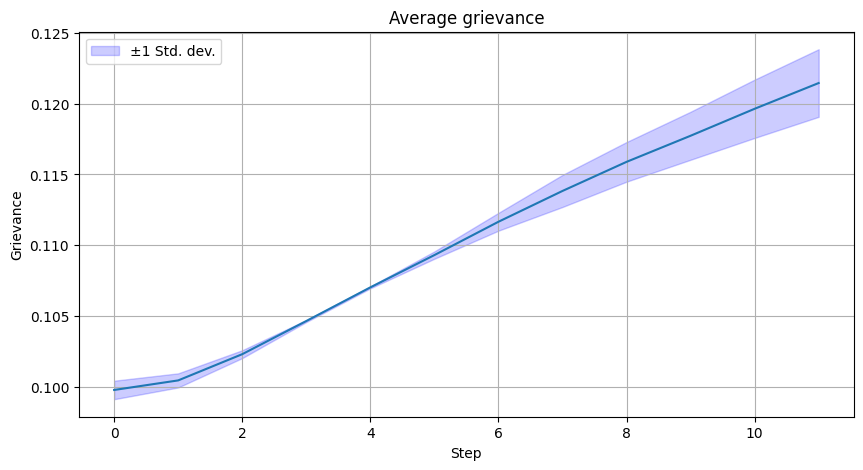

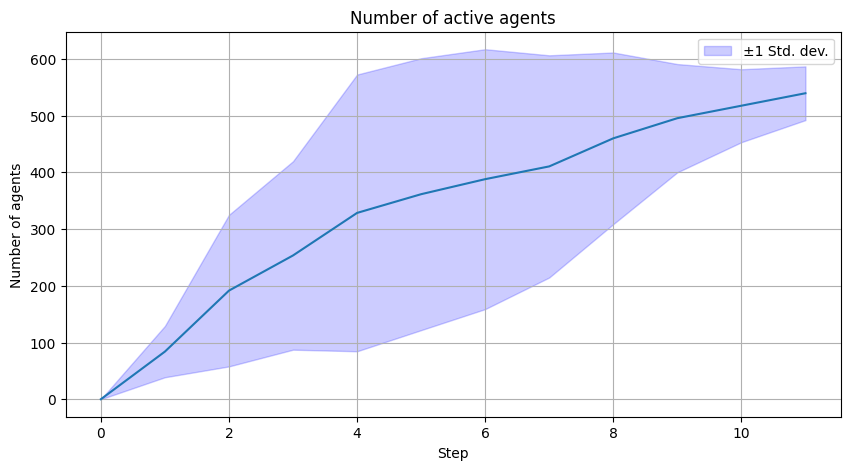

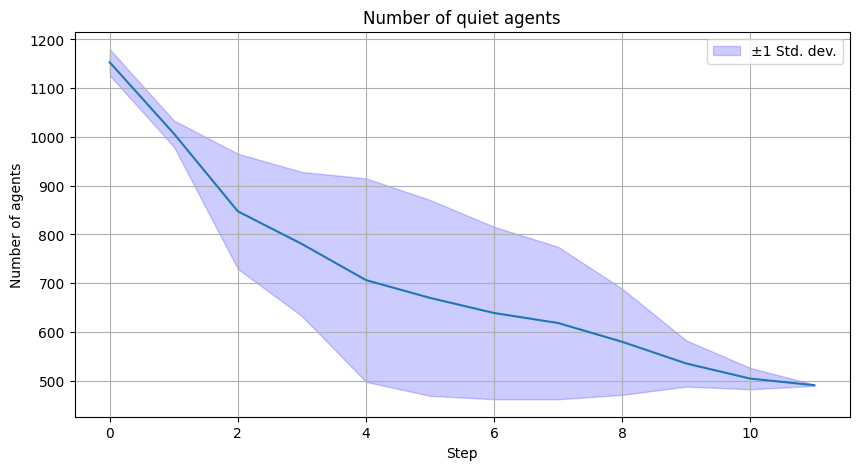

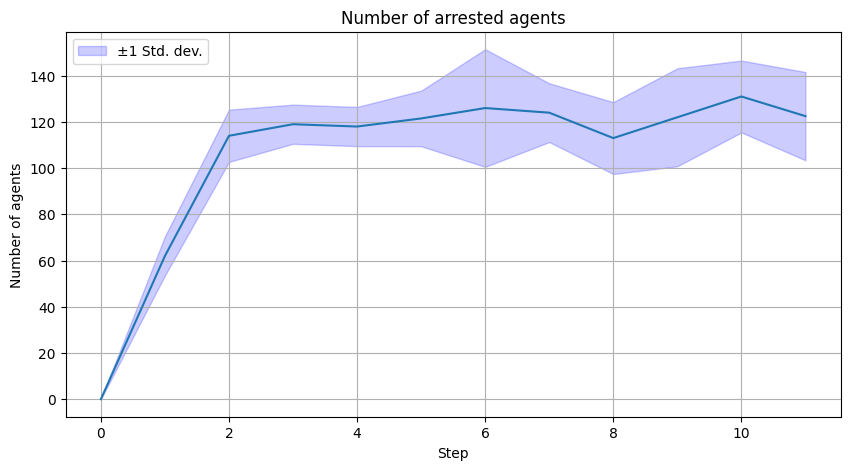

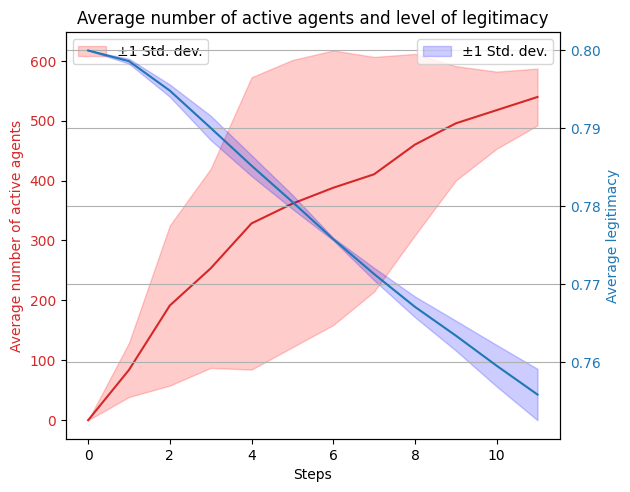

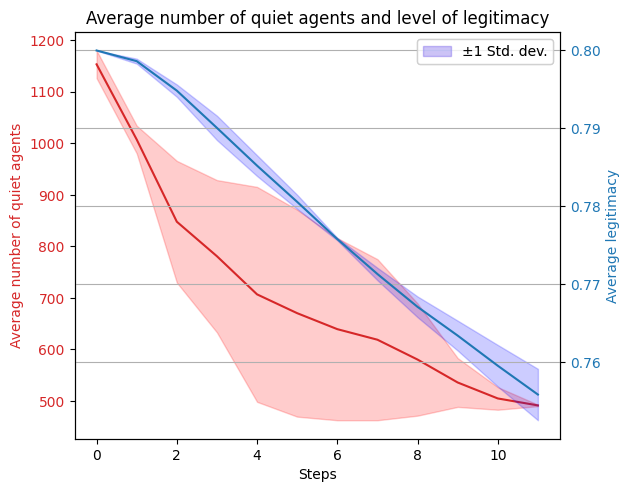

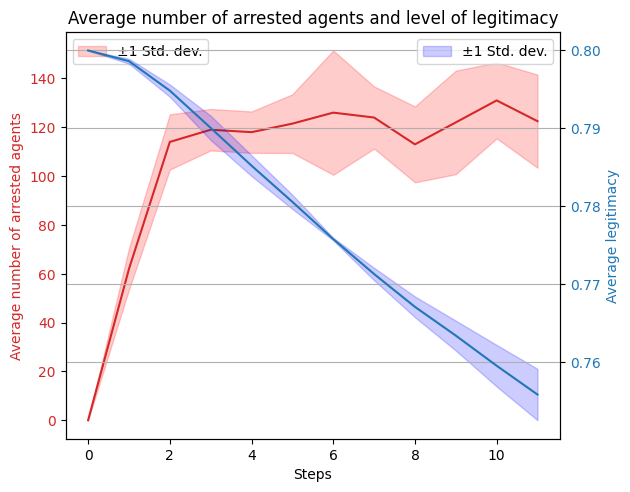

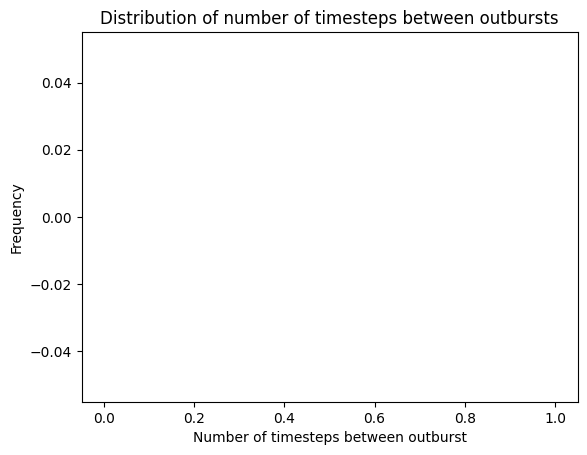

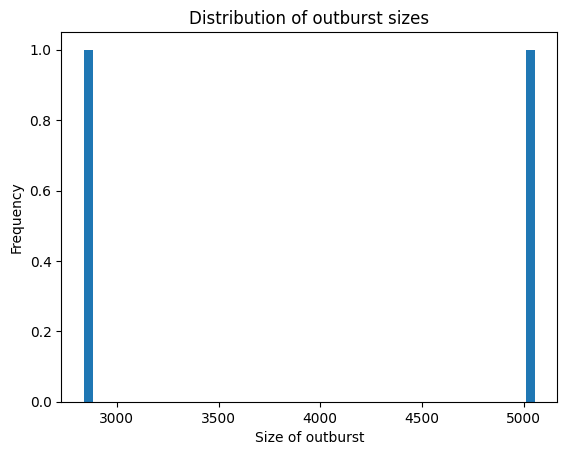

In [79]:
# ----------------------------------- BASIC STATISTICS -----------------------------------------------------------------------------------------
def sample_runs(
    n_runs=100,
    height=40,
    width=40,
    citizen_density=0.7,
    cop_density=0.074,
    citizen_vision=7,
    cop_vision=7,
    legitimacy=0.8,
    max_jail_term=1,
    max_iters=10,
):
    
    """ 
    Runs the model a number of times using the specified parameters, aggregates the results and
    presents them in different graphs.
    """

    intervals = []
    sizes = []
    agg_data = {"steps": [], "ripley_indexes": [], "legitimacy": [], "grievance": [], "active": [], "quiet": [], "arrested": [] }
    means_and_stds = {}

    for _ in tqdm(range(n_runs)):

        # Run the model
        seed = random.randint(1, 10000)
        model = EpsteinCivilViolence(
            height=height,
            width=width,
            citizen_density=citizen_density,
            cop_density=cop_density,
            citizen_vision=citizen_vision,
            cop_vision=cop_vision,
            legitimacy=legitimacy,
            max_jail_term=max_jail_term,
            max_iters=max_iters,
            seed=seed,
        )
        model.run_model()

        # Get statistics
        model_out = model.datacollector.get_model_vars_dataframe()
        data = preprocess_data(model_out)
        interval, size = calculate_interval_and_sizes(data)

        # Add statistics to the data
        intervals += interval
        sizes += size

        agg_data["steps"].extend(data["steps"])
        agg_data["ripley_indexes"].extend(data["ripley_indexes"])
        agg_data["legitimacy"].extend(data["legitimacies"])
        agg_data["grievance"].extend(data["grievances"])
        agg_data["active"].extend(data["active"])
        agg_data["quiet"].extend(data["quiet"])
        agg_data["arrested"].extend(data["arrested"])

    df = pd.DataFrame(agg_data)

    # Plot average change over the runs
    y_labels = ['Ripley index', 'Legitimacy', 'Grievance', 'Number of agents', 'Number of agents', 'Number of agents']
    titles = ['Ripley index of the model', 'Average legitimacy', 'Average grievance', 'Number of active agents', 'Number of quiet agents', 'Number of arrested agents']
    for idx, characteristic in enumerate(['ripley_indexes', 'legitimacy', 'grievance', 'active', 'quiet', 'arrested']):

        # Plot ripley index
        grouped = df.groupby('steps')[characteristic]
        means = grouped.mean()
        stds = grouped.std()
        means_and_stds[f"means{characteristic}"] = means
        means_and_stds[f"stds{characteristic}"] = stds

        plt.figure(figsize=(10, 5))
        plt.plot(means.index, means.values)
        plt.fill_between(means.index, means - stds, means + stds, color='blue', alpha=0.2, label='±1 Std. dev.')

        plt.xlabel('Step')
        plt.ylabel(f'{y_labels[idx]}')
        plt.title(f'{titles[idx]}')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot combined graphs
    for characteristic in ['active', 'quiet', 'arrested']:
        means_leg = means_and_stds["meanslegitimacy"]
        stds_leg = means_and_stds["stdslegitimacy"]
        means = means_and_stds[f"means{characteristic}"]
        stds = means_and_stds[f"stds{characteristic}"]

        # Plot combined data
        fig, ax1 = plt.subplots()

        color = 'tab:red' 
        ax1.set_xlabel('Steps')
        ax1.set_ylabel(f'Average number of {characteristic} agents', color=color)
        ax1.plot(means.index, means.values, color=color)
        ax1.fill_between(means.index, means - stds, means + stds, color='red', alpha=0.2, label='±1 Std. dev.')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.legend()

        ax2 = ax1.twinx() 

        color = 'tab:blue'
        ax2.set_ylabel('Average legitimacy', color=color)
        ax2.plot(means_leg.index, means_leg.values, color=color)
        ax2.fill_between(means_leg.index, means_leg - stds_leg, means_leg + stds_leg, color='blue', alpha=0.2, label='±1 Std. dev.')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend()

        fig.tight_layout()
        plt.title(f'Average number of {characteristic} agents and level of legitimacy')
        plt.grid(True)
        plt.show()


    # Plot outburst histograms

    # Plot intervals
    plt.hist(intervals, bins=5)
    plt.xlabel('Number of timesteps between outburst')
    plt.ylabel('Frequency')
    plt.title('Distribution of number of timesteps between outbursts')
    plt.show()

    # Plot sizes
    plt.hist(sizes, bins=50)
    plt.xlabel('Size of outburst')
    plt.ylabel('Frequency')
    plt.title('Distribution of outburst sizes')
    plt.show()

    return df

df = sample_runs(n_runs=2)